In [28]:
import pandas as pd
import numpy as np

In [29]:
df = pd.read_csv('data/SBAnational.csv', dtype='unicode')
pd.set_option('display.max_columns', None)
df.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"


# Copie pour perf

In [30]:
df_sba = df.copy()
df_sba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   LoanNr_ChkDgt      899164 non-null  object
 1   Name               899150 non-null  object
 2   City               899134 non-null  object
 3   State              899150 non-null  object
 4   Zip                899164 non-null  object
 5   Bank               897605 non-null  object
 6   BankState          897598 non-null  object
 7   NAICS              899164 non-null  object
 8   ApprovalDate       899164 non-null  object
 9   ApprovalFY         899164 non-null  object
 10  Term               899164 non-null  object
 11  NoEmp              899164 non-null  object
 12  NewExist           899028 non-null  object
 13  CreateJob          899164 non-null  object
 14  RetainedJob        899164 non-null  object
 15  FranchiseCode      899164 non-null  object
 16  UrbanRural         8

# nettoyage et formatage des data

In [31]:
def transform_curracy(df, columns):
    for col in columns:
        df[col] = df[col].replace(r'[\$ ,]', '', regex=True).astype(float)

def transform_date(df, columns, format='%d-%b-%y'):
    for col in columns:
        try:
            df[col] = pd.to_datetime(df[col], format=format, errors='raise')
        except ValueError:
            print('Erreur sur la date col:', col)
            pass

transform_curracy(df_sba, ['GrAppv', 'DisbursementGross', 'SBA_Appv', 'ChgOffPrinGr'])
transform_date(df_sba, ['ApprovalDate', 'DisbursementDate'])

df_sba.NAICS = df_sba.NAICS.astype(str).str[0:2].astype('category')
df_sba.ApprovalFY = df_sba.ApprovalFY.astype(str).str[0:4].astype(int)
df_sba.Term = df_sba.Term.astype(int)
df_sba.NoEmp = df_sba.NoEmp.astype(int)
df_sba.CreateJob = df_sba.CreateJob.astype(int)
df_sba.RetainedJob = df_sba.RetainedJob.astype(int)
df_sba.FranchiseCode = df_sba.FranchiseCode.astype('category')
df_sba.UrbanRural = df_sba.UrbanRural.astype('category')

df_sba.BankState = df_sba.BankState.astype('category')
df_sba.State = df_sba.State.astype('category')
df_sba.Zip = df_sba.Zip.astype('category')
df_sba.MIS_Status = df_sba.MIS_Status.astype('category')


## OHE de la target
On n'impute pas, on supprime car il n'y a que 1997 na sur 900000

In [32]:
from feature_engine.imputation import CategoricalImputer
from sklearn.preprocessing import LabelBinarizer

#imputer = CategoricalImputer(imputation_method='frequent', variables=['MIS_Status'])
#df_sba = imputer.fit_transform(df_sba)
df_sba.dropna(subset=['MIS_Status'], inplace=True)

df_sba.MIS_Status = LabelBinarizer().fit_transform(df_sba.loc[:,['MIS_Status']])
df_sba.MIS_Status = df_sba.MIS_Status.astype('category')

# display(df_sba.head(2))
# df_sba.info()


In [33]:
df_sba.LowDoc = df_sba.LowDoc.replace(r'[C1SRA0]', np.nan, regex=True)
df_sba.RevLineCr = df_sba.RevLineCr.replace(r'[0T`1C32R7A5\.,4\-Q]', np.nan, regex=True)
df_sba.NewExist = df_sba.NewExist.replace(r'[0]', np.nan, regex=True)

In [34]:
#np.round(df_sba[['LowDoc', 'GrAppv']].loc[df_sba.LowDoc.isna()].describe(), 2)


## Imputer
### LowDoc RevLineCr NewExist FranchiseCode

In [35]:
from feature_engine.imputation import RandomSampleImputer
imputer = RandomSampleImputer()

# FranchiseCode
df_sba.FranchiseCode = df_sba.FranchiseCode.astype(int)
df_sba.loc[df_sba.FranchiseCode > 0, 'FranchiseCode'] = 1

# LowDoc
df_sba.LowDoc = np.where(df_sba.LowDoc.isna(), 
                    np.where(df_sba.GrAppv < 150000, 1, 0), 
                    np.where(df_sba.GrAppv >= 150000, 0, 1))

# RevLineCr
result = imputer.fit_transform(df_sba.loc[:,['RevLineCr']])
df_sba.RevLineCr = result['RevLineCr']
df_sba.RevLineCr = LabelBinarizer().fit_transform(df_sba.loc[:,['RevLineCr']])
df_sba.RevLineCr = df_sba.RevLineCr.astype('category')

# NewExist
result = imputer.fit_transform(df_sba.loc[:,['NewExist']])
df_sba.NewExist = result['NewExist']
imputer = CategoricalImputer(imputation_method='frequent', variables=['NewExist'])
df_sba = imputer.fit_transform(df_sba)
df_sba.NewExist = df_sba.NewExist.astype('category')

# on remplace les na de BankState avec la valeur de State (fortement corrélés)
df_sba.BankState = np.where(df_sba.BankState.isna(), df_sba.State, df_sba.BankState)
# Il en reste 1. City = Pennsville -> New Jersey -> BankState = NJ
df_sba.BankState = np.where(df_sba.BankState.isna(), 'NJ', df_sba.BankState)
# On supprime State
# df_sba.drop(columns=['State'], inplace=True)

df_sba.Zip = df_sba.Zip.astype(str).str[0:2].astype(int)
df_sba.NAICS = df_sba.NAICS.astype(object).str[0:1].astype(int)

# v = df_sba.BankState.value_counts()
# for idx,name in enumerate(v.index.tolist()):
#     if v.iloc[idx] < 10000:
#         df_sba.loc[df_sba['BankState'] == name, 'BankState'] = 'unknown'

df_sba.head(1)



,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47,FIFTH THIRD BANK,OH,4,1997-02-28,1997,84,4,2,0,0,1,0,0,1,NaN,1999-02-28,60000.0,$0.00,1,0.0,60000.0,48000.0


In [36]:
import requests

url = 'https://www.mappr.co/political-maps/us-regions-map/'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

list = pd.read_html(r.text)[0]
list.head(1)

/var/folders/zp/c97k147160ddnklbfc2rk3hr0000gn/T/ipykernel_36154/1122057560.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  list = pd.read_html(r.text)[0]


,Abbreviation,State Name,Region
0,AL,Alabama,Southeast


In [37]:
df_sba['region'] = np.nan

for index, row in list.iterrows():
    df_sba.loc[df_sba.BankState == row['Abbreviation'], 'region'] = row['Region']

df_sba.loc[df_sba.region.isna(), 'region'] = 'other'

/var/folders/zp/c97k147160ddnklbfc2rk3hr0000gn/T/ipykernel_36154/3115867657.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Southeast' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sba.loc[df_sba.BankState == row['Abbreviation'], 'region'] = row['Region']


In [38]:
df_sba.to_pickle('data/SBAmodel.pickle')

In [64]:
from sklearn import set_config
set_config(transform_output = "pandas")

df.Zip = df.Zip.astype(str).str[0:2].astype(int)
df.NAICS = df.NAICS.astype(object).str[0:1].astype(int)

v = df.BankState.value_counts()
for idx,name in enumerate(v.index.tolist()):
    if v.iloc[idx] < 10000:
        df.loc[df['BankState'] == name, 'BankState'] = 'unknown'

y = df.MIS_Status
df = df[['Zip', 'BankState',
       'NAICS', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'GrAppv', 'SBA_Appv']]

display(df.head(1))
print(df.shape)

,Zip,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,GrAppv,SBA_Appv
0,47,OH,4,84,4,2,0,0,1,0,0,1,60000.0,48000.0


(897167, 14)


In [12]:
import pandas as pd
import sweetviz as sv

sweet = pd.read_pickle('data/SBAmodel.pickle')
sweet = sweet[['Term', 'UrbanRural', 'FranchiseCode', 'LowDoc', 'GrAppv', 'RetainedJob', 'MIS_Status']]

sweet.MIS_Status = sweet.MIS_Status.astype(bool)
# sweet_report = sv.analyze(sweet, 'MIS_Status')

sweet_report = sv.compare_intra(sweet, sweet.UrbanRural == 1, ['LowDoc 1', 'LowDoc 0'], "MIS_Status")

sweet_report.show_html(filepath='sweetviz_eda/_lowdoc.html')

/Volumes/DD 250/dev/_simplon/US-SBA/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report sweetviz_eda/lowdoc.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


<Axes: >

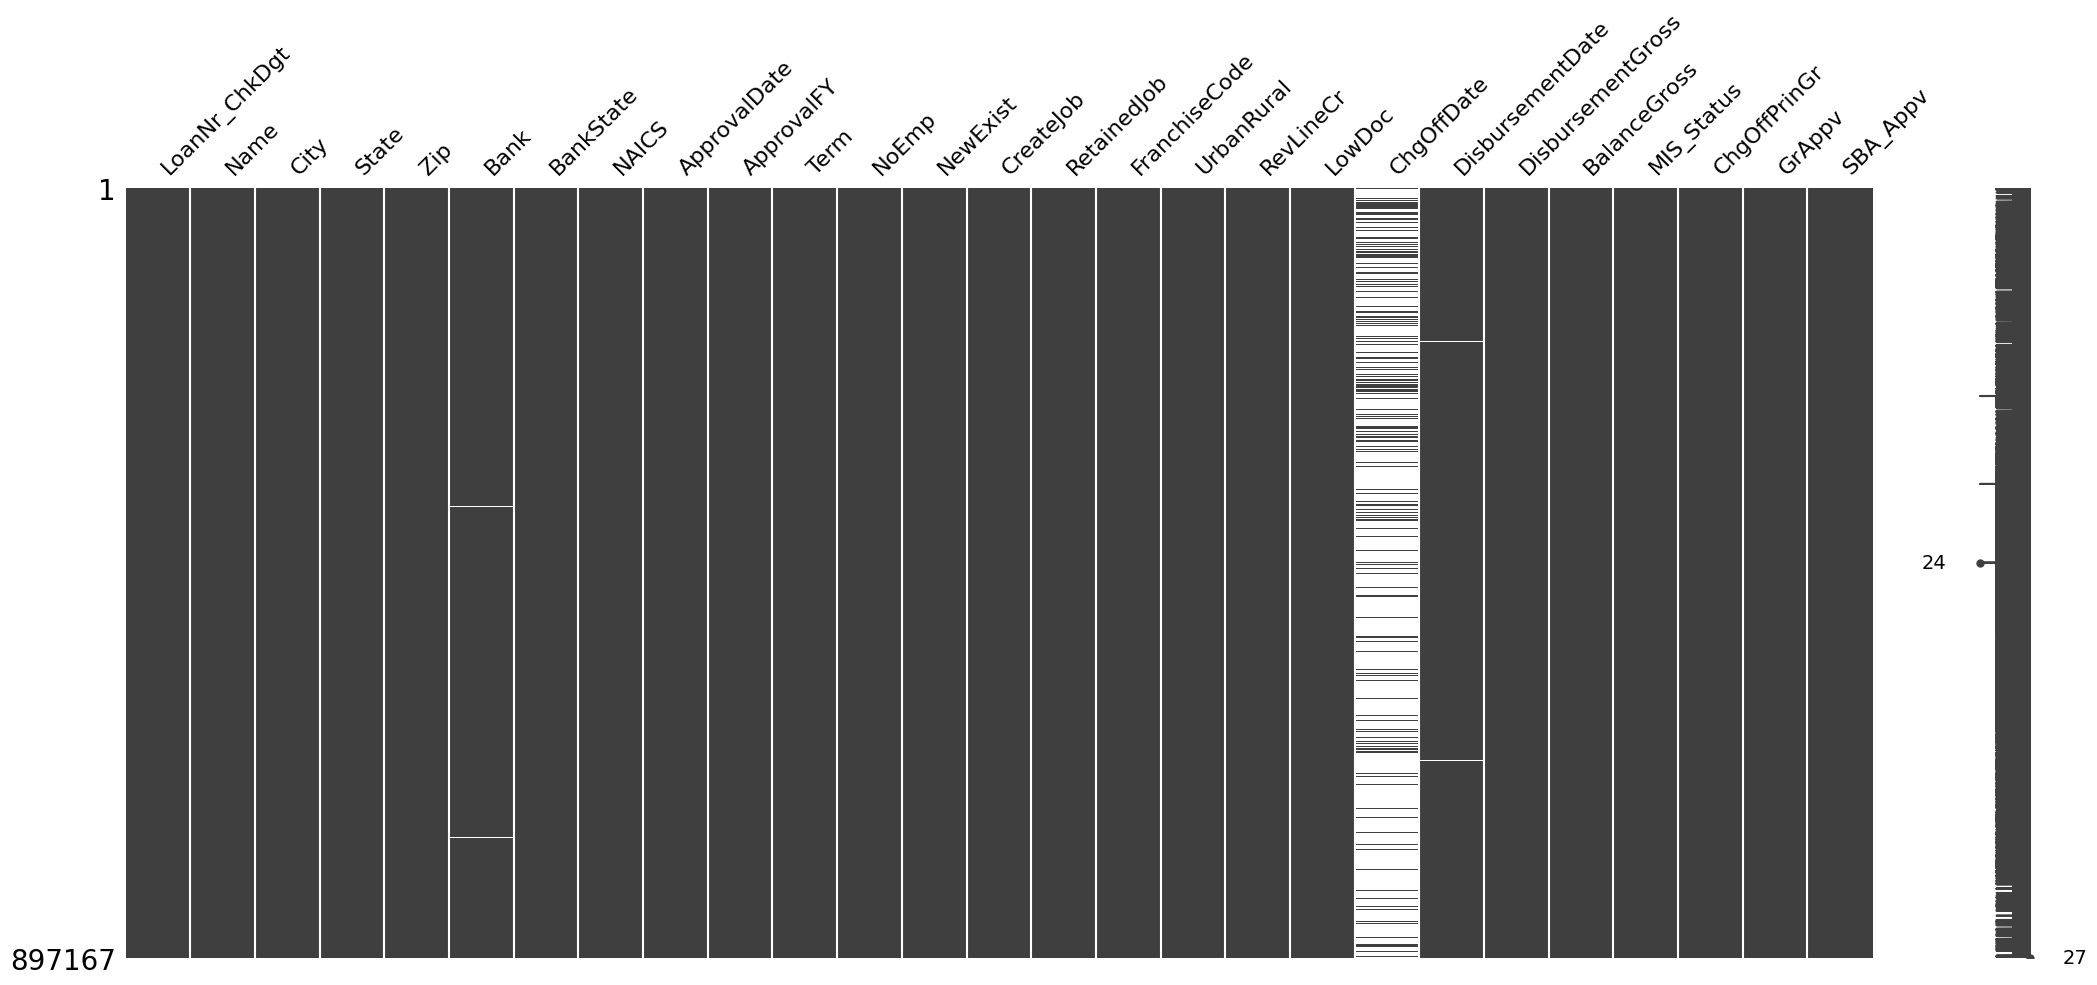

In [9]:
import missingno as msno
msno.matrix(df_sba)

In [227]:
import sweetviz as sv
#print(df_sba.info())
feature_config = sv.FeatureConfig(force_num=["MIS_Status"])
df_sba.MIS_Status = df_sba.MIS_Status.astype(bool)
sweet_report = sv.analyze(df_sba, 'MIS_Status', pairwise_analysis='off')
sweet_report.show_html(filepath='sweetviz_eda/brut.html')

Feature: MIS_Status (TARGET)                 |▌         | [  5%]   01:10 -> (22:15 left)
Feature: GrAppv                              |██████████| [100%]   00:07 -> (00:00 left)


Report sweetviz_eda/brut.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
# sweet_report = sv.compare_intra(df_sba, df_sba["Bank"] == "BANK OF AMERICA NATL ASSOC", ['BANK OF AMERICA NATL ASSOC', 'Autre'], "MIS_Status", feature_config)
# sweet_report.show_html()